In [1]:
import pandas as pd

## Read data

In [2]:
df = pd.read_csv('./data/AdSmartABdata.csv')

In [3]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [37]:
df.describe()

,hour,platform_os,yes,no
count,8077.000000,8077.000000,8077.000000,8077.000000
mean,11.615080,5.947134,0.070818,0.083075
std,5.734879,0.224333,0.256537,0.276013
min,0.000000,5.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000
75%,15.000000,6.000000,0.000000,0.000000
max,23.000000,7.000000,1.000000,1.000000


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


# Counts of categorical Variables

## Experiment value counts

In [39]:
df['experiment'].value_counts()

control    4071
exposed    4006
Name: experiment, dtype: int64

## Experiment value visualization

<AxesSubplot:>

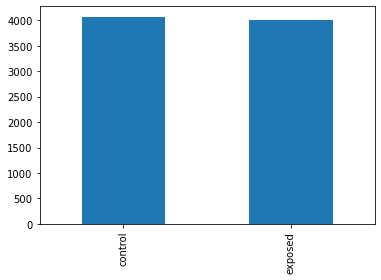

In [23]:
df['experiment'].value_counts().plot(kind='bar')

## Device make value counts

In [31]:
df['device_make'].value_counts()

Generic Smartphone    4743
iPhone                 433
Samsung SM-G960F       203
Samsung SM-G973F       154
Samsung SM-G950F       148
                      ... 
Samsung SM-A605G         1
Samsung GT-P5210         1
Samsung SM-G960U1        1
Samsung SM-A750GN        1
Samsung SM-N9750         1
Name: device_make, Length: 270, dtype: int64

## Browser value counts

In [35]:
df['browser'].value_counts()

Chrome Mobile                 4554
Chrome Mobile WebView         1489
Samsung Internet               824
Facebook                       764
Mobile Safari                  337
Chrome Mobile iOS               51
Mobile Safari UI/WKWebView      44
Pinterest                        3
Chrome                           3
Opera Mobile                     3
Firefox Mobile                   1
Android                          1
Opera Mini                       1
Puffin                           1
Edge Mobile                      1
Name: browser, dtype: int64

<AxesSubplot:title={'center':'Browsers'}>

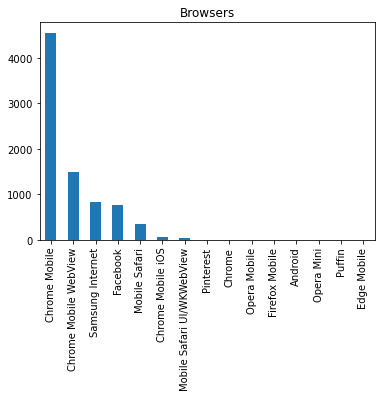

In [40]:
df['browser'].value_counts().plot(kind='bar', title='Browsers')

## Hour values plot

<AxesSubplot:title={'center':'Hour values'}, ylabel='Density'>

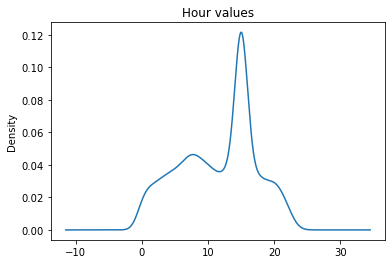

In [15]:
df['hour'].plot(kind='kde', title='Hour values')

## Yes answers plot

<AxesSubplot:title={'center':'yes answers'}, ylabel='Density'>

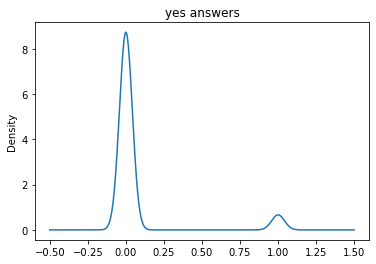

In [17]:
df['yes'].plot(kind='kde', title='Yes Answers')

## No answers plot

<AxesSubplot:title={'center':'No Answers'}, ylabel='Density'>

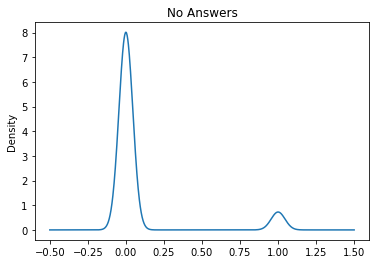

In [36]:
df['no'].plot(kind='kde', title='No Answers')

## Platform_Os values plot

<AxesSubplot:title={'center':'Platform_os'}, ylabel='Density'>

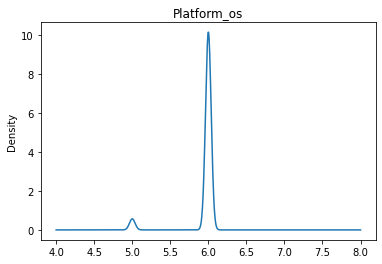

In [41]:
df['platform_os'].plot(kind='kde', title='Platform_os')